##XGBoost Automated Hyperparameter Tuning

The project aims to create a predictive model to forecast whether a basketball player will get drafted into the NBA based on their performance matrices.

In this experiment, I aim to determine how well an XGBoost model can predict the drafting of players in NBA.

The metric used to assess the performance of classification model is AUROC.


##Import packages and load the dataset

In [12]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

I have created a reprository 'Adv_MLA' on my github and uploaded the train and test datasets

In [13]:
#set path to project folder
import sys
sys.path.append('C:/Users/saumy/OneDrive/Desktop/Semester-3/AdvMLA/Adv_MLA')

# Import the required functions or classes from the module
from src.data.datapreprocess import DataProcessor

# Create an instance of the DataProcessor class
data_processor = DataProcessor()

# Load the data
df_train = pd.read_csv('https://raw.githubusercontent.com/bhutanisaumya/AMLA/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/bhutanisaumya/AMLA/main/test.csv')



##Data Exploration
I will be performing data explorations on both test and train datasets.

###Train Dataset

In [14]:
#explore the train data
data_processor.explore_data(df_train)

First 5 rows:
            team conf  GP  Min_per   Ortg   usg   eFG  TS_per  ORB_per  \
0  South Alabama   SB  26     29.5   97.3  16.6  42.5   44.43      1.6   
1       Utah St.  WAC  34     60.9  108.3  14.9  52.4   54.48      3.8   
2  South Florida   BE  27     72.0   96.2  21.8  45.7   47.98      2.1   
3     Pepperdine  WCC  30     44.5   97.7  16.0  53.6   53.69      4.1   
4        Pacific   BW  33     56.2   96.5  22.0  52.8   54.31      8.3   

   DRB_per  ...     dgbpm    oreb    dreb    treb     ast     stl     blk  \
0      4.6  ... -1.941150  0.1923  0.6154  0.8077  1.1923  0.3462  0.0385   
1      6.3  ... -0.247934  0.6765  1.2647  1.9412  1.8235  0.4118  0.2353   
2      8.0  ... -0.883163  0.6296  2.3333  2.9630  1.9630  0.4815  0.0000   
3      9.4  ... -0.393459  0.7000  1.4333  2.1333  1.1000  0.5667  0.1333   
4     18.6  ... -0.668318  1.4242  3.3030  4.7273  0.8485  0.4545  0.3333   

       pts                             player_id  drafted  
0   3.8846  7be2ae

team          0
conf          0
GP            0
Min_per       0
Ortg          0
             ..
stl          38
blk          38
pts          38
player_id     0
drafted       0
Length: 64, dtype: int64


###Test Dataset

In [ ]:
#explore the test data
data_processor.explore_data(df_test)

##Data Preparation and cleaning

###Train Dataset

In [ ]:
#sum of null values in the dataframe
df_train.isnull().sum()

In [ ]:
#heatmap highlighing null values in the dataframe
sns.heatmap(df_train.isnull(), yticklabels = False)

The above heatmap shows null values in the dataframe.
To handle null values in these columns, I will impute the null values with mean values.
But for the columns where half of the rows are empty.I will not make any imputations rather I will drop the column as imputing with mean of very less data points will lead to inaccurate data.

In [ ]:
#copy the dataframe
df_train_clean = df_train.copy()

In [16]:
#checking missimng values in specific columns
columns_to_check = [ 'Rec_Rank', 'pick', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio']
missing_counts = df_train_clean[columns_to_check].isnull().sum()

print("Missing Value Counts:")
print(missing_counts)


Missing Value Counts:
Rec_Rank               39055
pick                   54705
midmade                 6081
midmade_midmiss         6081
rim_ratio               9464
mid_ratio               9688
dunksmade               6081
dunksmiss_dunksmade     6081
dunks_ratio            30793
dtype: int64


The features ‘pick’ and  'Rec_Rank' have a high percentage of missing values of more than 97% and 69%, respectively. Therefore, I am dropping these columns.

In [17]:
# List of columns to drop
cols_to_drop = ['Rec_Rank', 'pick']

# Drop the specified columns
df_train_clean.drop(columns=cols_to_drop, inplace=True)

In [18]:
#calculate mean (ast_tov, rimmrade, rimmade_rimmiss, midmade, midmade_midmiss, dunksmade, dunksmiss_dunksmade)
ast_tov_train_mean = df_train_clean['ast_tov'].mean()
rimmade_train_mean = df_train_clean['rimmade'].mean()
rimmade_rimmiss_train_mean = df_train_clean['rimmade_rimmiss'].mean()
midmade_train_mean = df_train_clean['midmade'].mean()
midmade_midmiss_train_mean = df_train_clean['midmade_midmiss'].mean()
dunksmade_train_mean = df_train_clean['dunksmade'].mean()
dunksmiss_dunksmade_train_mean = df_train_clean['dunksmiss_dunksmade'].mean()

#imputing the missing values with mean
df_train_clean['ast_tov'] = df_train_clean['ast_tov'].fillna(ast_tov_train_mean)
df_train_clean['rimmade'] = df_train_clean['rimmade'].fillna(rimmade_train_mean)
df_train_clean['rimmade_rimmiss'] = df_train_clean['rimmade_rimmiss'].fillna(rimmade_rimmiss_train_mean)
df_train_clean['midmade'] = df_train_clean['midmade'].fillna(midmade_train_mean)
df_train_clean['midmade_midmiss'] = df_train_clean['midmade_midmiss'].fillna(midmade_midmiss_train_mean)
df_train_clean['dunksmade'] = df_train_clean['dunksmade'].fillna(dunksmade_train_mean)
df_train_clean['dunksmiss_dunksmade'] = df_train_clean['dunksmiss_dunksmade'].fillna(dunksmiss_dunksmade_train_mean)

In [19]:
# Calculate ratio (rim_ratio, mid_ratio, dunks_ratio)
rim_ratio_train = df_train_clean['rimmade'] / df_train_clean['rimmade_rimmiss']
mid_ratio_train = df_train_clean['midmade'] / df_train_clean['midmade_midmiss']
dunks_ratio_train = df_train_clean['dunksmade'] / df_train_clean['dunksmiss_dunksmade']

# Impute the missing values with calculated ratios
df_train_clean['rim_ratio'] = df_train_clean['rim_ratio'].fillna(rim_ratio_train)
df_train_clean['mid_ratio'] = df_train_clean['mid_ratio'].fillna(mid_ratio_train)
df_train_clean['dunks_ratio'] = df_train_clean['dunks_ratio'].fillna(dunks_ratio_train)


In [20]:
# List of ratio columns
ratio_columns = ['rim_ratio', 'mid_ratio', 'dunks_ratio']

# Replace NaN values with 0 in the ratio columns
for col in ratio_columns:
    df_train_clean[col][pd.isna(df_train_clean[col])] = 0


In [21]:
#check for null values after imputations
columns_to_check = [ 'yr', 'ht', 'num']
missing = df_train_clean[columns_to_check].isnull().sum()

print("Missing Value Counts:")
print(missing)

Missing Value Counts:
yr      274
ht       80
num    4669
dtype: int64


The columns 'yr', 'ht', and 'num' contain a lot of irregularities. Since the data is unreliable. Thus I have decided to remove these columns.

In [22]:
# List of columns to drop
to_drop = ['yr', 'ht', 'num']
# Drop the specified columns
df_train_clean.drop(columns=to_drop, inplace=True)

In [23]:
#check for null values after imputations
df_train_clean.isnull().sum()

team                    0
conf                    0
GP                      0
Min_per                 0
Ortg                    0
usg                     0
eFG                     0
TS_per                  0
ORB_per                 0
DRB_per                 0
AST_per                 0
TO_per                  0
FTM                     0
FTA                     0
FT_per                  0
twoPM                   0
twoPA                   0
twoP_per                0
TPM                     0
TPA                     0
TP_per                  0
blk_per                 0
stl_per                 0
ftr                     0
porpag                  0
adjoe                   0
pfr                     0
year                    0
type                    0
ast_tov                 0
rimmade                 0
rimmade_rimmiss         0
midmade                 0
midmade_midmiss         0
rim_ratio               0
mid_ratio               0
dunksmade               0
dunksmiss_dunksmade     0
dunks_ratio 

In [24]:
# List of columns to impute with average
columns_to_impute = [
    'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm',
    'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts'
]

# Impute the average value to specified columns
for col in columns_to_impute:
    avg_value = df_train_clean[col].mean()
    df_train_clean[col].fillna(avg_value, inplace=True)

In [25]:
#check for null values
df_train_clean.isnull().sum()

team                   0
conf                   0
GP                     0
Min_per                0
Ortg                   0
usg                    0
eFG                    0
TS_per                 0
ORB_per                0
DRB_per                0
AST_per                0
TO_per                 0
FTM                    0
FTA                    0
FT_per                 0
twoPM                  0
twoPA                  0
twoP_per               0
TPM                    0
TPA                    0
TP_per                 0
blk_per                0
stl_per                0
ftr                    0
porpag                 0
adjoe                  0
pfr                    0
year                   0
type                   0
ast_tov                0
rimmade                0
rimmade_rimmiss        0
midmade                0
midmade_midmiss        0
rim_ratio              0
mid_ratio              0
dunksmade              0
dunksmiss_dunksmade    0
dunks_ratio            0
drtg                   0


###Test Dataset

In [26]:
#sum of null values in the dataframe
df_test.isnull().sum()

team         0
conf         0
GP           0
Min_per      0
Ortg         0
            ..
ast          0
stl          0
blk          0
pts          0
player_id    0
Length: 63, dtype: int64

<Axes: >

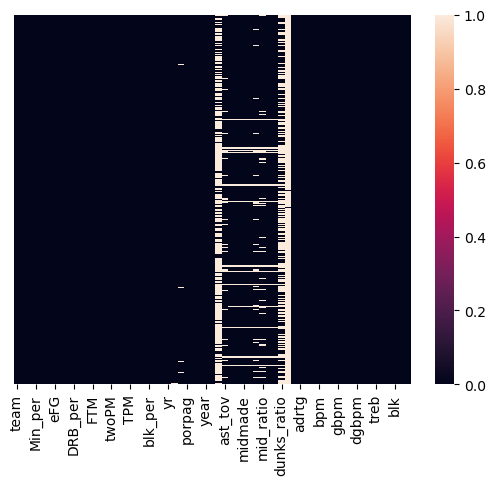

In [27]:
#heatmap highlighing null values in the dataframe
sns.heatmap(df_test.isnull(), yticklabels = False)

The above heatmap shows null values in the dataframe.
To handle null values in these columns, I will impute the null values with mean values.
But for the columns where half of the rows are empty.I will not make any imputations rather I will drop the column as imputing with mean of very less data points will lead to inaccurate data.

In [28]:
#copy the dataframe
df_test_clean = df_test.copy()

Performing similar imputations as performed in training dataset

In [29]:
# List of columns to drop
cols_to_drop = ['Rec_Rank', 'pick']

# Drop the specified columns
df_test_clean.drop(columns=cols_to_drop, inplace=True)

In [30]:
#calculate mean (ast_tov, rimmrade, rimmade_rimmiss, midmade, midmade_midmiss, dunksmade, dunksmiss_dunksmade)
ast_tov_test_mean = df_test_clean['ast_tov'].mean()
rimmade_test_mean = df_test_clean['rimmade'].mean()
rimmade_rimmiss_test_mean = df_test_clean['rimmade_rimmiss'].mean()
midmade_test_mean = df_test_clean['midmade'].mean()
midmade_midmiss_test_mean = df_test_clean['midmade_midmiss'].mean()
dunksmade_test_mean = df_test_clean['dunksmade'].mean()
dunksmiss_dunksmade_test_mean = df_test_clean['dunksmiss_dunksmade'].mean()

#impute the null values with mean
df_test_clean['ast_tov'] = df_test_clean['ast_tov'].fillna(ast_tov_test_mean)
df_test_clean['rimmade'] = df_test_clean['rimmade'].fillna(rimmade_test_mean)
df_test_clean['rimmade_rimmiss'] = df_test_clean['rimmade_rimmiss'].fillna(rimmade_rimmiss_test_mean)
df_test_clean['midmade'] = df_test_clean['midmade'].fillna(midmade_test_mean)
df_test_clean['midmade_midmiss'] = df_test_clean['midmade_midmiss'].fillna(midmade_midmiss_test_mean)
df_test_clean['dunksmade'] = df_test_clean['dunksmade'].fillna(dunksmade_test_mean)
df_test_clean['dunksmiss_dunksmade'] = df_test_clean['dunksmiss_dunksmade'].fillna(dunksmiss_dunksmade_test_mean)

In [31]:
# Calculate ratio (rim_ratio, mid_ratio, dunks_ratio)
rim_ratio_test = df_test_clean['rimmade'] / df_test_clean['rimmade_rimmiss']
mid_ratio_test = df_test_clean['midmade'] / df_test_clean['midmade_midmiss']
dunks_ratio_test = df_test_clean['dunksmade'] / df_test_clean['dunksmiss_dunksmade']

# Impute the null values with calculated ratios
df_test_clean['rim_ratio'] = df_test_clean['rim_ratio'].fillna(rim_ratio_test)
df_test_clean['mid_ratio'] = df_test_clean['mid_ratio'].fillna(mid_ratio_test)
df_test_clean['dunks_ratio'] = df_test_clean['dunks_ratio'].fillna(dunks_ratio_test)


In [32]:
# List of ratio columns
ratio_columns = ['rim_ratio', 'mid_ratio', 'dunks_ratio']

# Replace NaN values with 0 in the ratio columns
for col in ratio_columns:
    df_test_clean[col][pd.isna(df_test_clean[col])] = 0


The columns 'yr', 'ht', and 'num' contain a lot of irregularities. Since the data is unreliable. Thus I have decided to remove these columns.

In [33]:
# List of columns to drop
to_drop = ['yr', 'ht', 'num']
# Drop the specified columns
df_test_clean.drop(columns=to_drop, inplace=True)

In [34]:
#check for null values after imputations
df_test_clean.isnull().sum()

team                   0
conf                   0
GP                     0
Min_per                0
Ortg                   0
usg                    0
eFG                    0
TS_per                 0
ORB_per                0
DRB_per                0
AST_per                0
TO_per                 0
FTM                    0
FTA                    0
FT_per                 0
twoPM                  0
twoPA                  0
twoP_per               0
TPM                    0
TPA                    0
TP_per                 0
blk_per                0
stl_per                0
ftr                    0
porpag                 0
adjoe                  0
pfr                    0
year                   0
type                   0
ast_tov                0
rimmade                0
rimmade_rimmiss        0
midmade                0
midmade_midmiss        0
rim_ratio              0
mid_ratio              0
dunksmade              0
dunksmiss_dunksmade    0
dunks_ratio            0
drtg                   1


In [35]:
# List of columns to impute with average
columns_to_impute = [
    'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'ogbpm', 'dgbpm'
]

# Impute the average value to specified columns
for col in columns_to_impute:
    avg_value = df_test_clean[col].mean()
    df_test_clean[col].fillna(avg_value, inplace=True)

##Identifying relationships
I will generate correlation matrix to understand the relationship between the target feature and other features.

<Axes: >

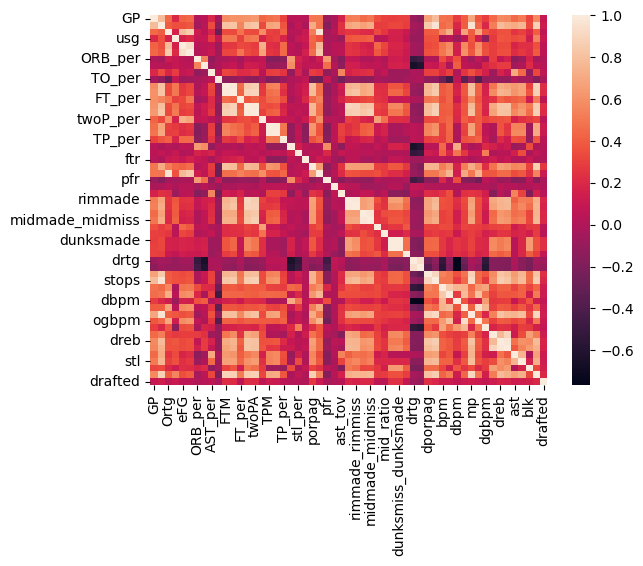

In [36]:
corr_matrix = df_train_clean.corr()
sns.heatmap(corr_matrix)

In [37]:
corr_matrix

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,drafted
GP,1.000000,0.780850,0.443309,0.193908,0.416546,0.434722,-0.005510,0.037280,0.193153,-0.044621,...,0.375688,0.287354,0.444542,0.570031,0.557943,0.444210,0.507958,0.312446,0.566343,0.096567
Min_per,0.780850,1.000000,0.398857,0.349819,0.346221,0.379121,-0.051825,0.033872,0.335007,-0.119816,...,0.437588,0.192223,0.518478,0.780668,0.732328,0.707774,0.754155,0.329065,0.869411,0.130029
Ortg,0.443309,0.398857,1.000000,0.165410,0.784157,0.849692,0.118376,0.043333,0.180594,-0.285193,...,0.703379,0.369924,0.310267,0.354244,0.358698,0.251685,0.289726,0.201221,0.405889,0.068761
usg,0.193908,0.349819,0.165410,1.000000,0.160583,0.205958,0.087382,0.092843,0.281739,0.080861,...,0.138026,-0.131388,0.271286,0.374454,0.359218,0.333903,0.356104,0.136080,0.546044,0.104023
eFG,0.416546,0.346221,0.784157,0.160583,1.000000,0.934169,0.034630,0.057518,0.074258,-0.062752,...,0.583982,0.338541,0.285155,0.329385,0.332351,0.175005,0.232861,0.228164,0.351124,0.052540
TS_per,0.434722,0.379121,0.849692,0.205958,0.934169,1.000000,0.024408,0.051895,0.104640,-0.058381,...,0.614393,0.353101,0.284585,0.348780,0.345813,0.217745,0.268995,0.214606,0.390201,0.058321
ORB_per,-0.005510,-0.051825,0.118376,0.087382,0.034630,0.024408,1.000000,0.526528,-0.119004,-0.029690,...,0.069681,-0.017234,0.282707,0.079074,0.155175,-0.141088,-0.078666,0.170597,-0.034979,0.012876
DRB_per,0.037280,0.033872,0.043333,0.092843,0.057518,0.051895,0.526528,1.000000,-0.074031,-0.003540,...,-0.002357,0.175686,0.236822,0.276478,0.278078,-0.061808,-0.005274,0.209791,0.058259,0.033361
AST_per,0.193153,0.335007,0.180594,0.281739,0.074258,0.104640,-0.119004,-0.074031,1.000000,0.058321,...,0.257076,0.156388,-0.067338,0.166012,0.093242,0.697033,0.441994,-0.119554,0.319018,0.055421
TO_per,-0.044621,-0.119816,-0.285193,0.080861,-0.062752,-0.058381,-0.029690,-0.003540,0.058321,1.000000,...,-0.385840,-0.113922,-0.093106,-0.110122,-0.110329,-0.005675,-0.057686,-0.051947,-0.181823,-0.032557


In [38]:
corr_features = corr_matrix.nlargest(40, 'drafted')['drafted'].index
print(corr_features)

Index(['drafted', 'porpag', 'dunksmade', 'dunksmiss_dunksmade', 'dporpag',
       'twoPM', 'FTM', 'FTA', 'twoPA', 'midmade', 'pts', 'midmade_midmiss',
       'rimmade', 'stops', 'dreb', 'treb', 'rimmade_rimmiss', 'blk', 'mp',
       'Min_per', 'stl', 'oreb', 'bpm', 'ast', 'gbpm', 'obpm', 'TPM', 'ogbpm',
       'adjoe', 'TPA', 'usg', 'GP', 'dgbpm', 'dunks_ratio', 'dbpm', 'Ortg',
       'FT_per', 'TS_per', 'rim_ratio', 'AST_per'],
      dtype='object')


<Axes: >

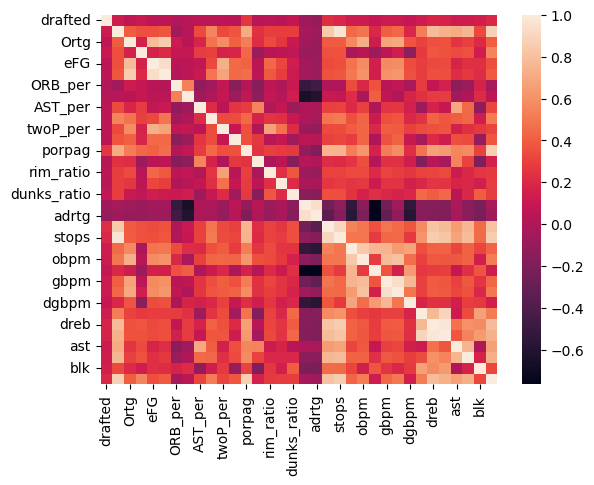

In [39]:
corr_matrix = df_train_clean[['drafted', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'FT_per', 'twoP_per', 'TP_per', 'porpag', 'ast_tov','rim_ratio', 'mid_ratio', 'dunks_ratio', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm','gbpm', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']].corr()
sns.heatmap(corr_matrix, annot=False)

## Data Splitting

In [40]:
from sklearn.model_selection import train_test_split

# Extract the relevant features and target variable
features = ['Min_per', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'FT_per',
            'twoP_per', 'TP_per', 'porpag', 'ast_tov', 'rim_ratio', 'mid_ratio', 'dunks_ratio',
            'drtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'ogbpm',
            'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']
target = ['drafted']

# Extract the features and target from the DataFrame
X = df_train_clean[features]
y = df_train_clean[target]

# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the split datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (44872, 31)
X_val shape: (11219, 31)
y_train shape: (44872, 1)
y_val shape: (11219, 1)


In [41]:
X_test = df_test_clean[['Min_per', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'FT_per', 'twoP_per', 'TP_per', 'porpag', 'ast_tov','rim_ratio', 'mid_ratio', 'dunks_ratio', 'drtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm','gbpm', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']]

#Resampling of Training data

Class 0: 55555
Class 1: 536
Proportion: 103.65 : 1


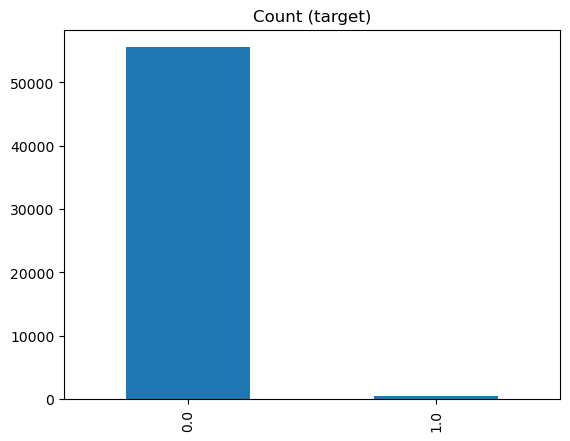

In [42]:
#barplot showing imbalances in dependent feature
target_count = df_train_clean.drafted.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

from the above barplot, it is clear that '1' is a minority class.
Resampling of data is important here as there is a  significant class imbalance, wherein one class represents only a small fraction of the dataset. Thus,the model can be biased towards the majority class and making it difficult to predict the minority class accurately.

Resampling the Minority class
I will be performing oversampling of minority class(1) using SMOTE(Synthetic Minority Over-sampling Technique)

In [43]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [44]:
#intall and load necessary libraries
!pip install imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)
X_val_sm, y_val_sm = smote.fit_resample(X_val, y_val)

In [45]:
# Print the number of samples before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling(training set):")
print(y_sm.value_counts())
print("After oversampling(validation set):")
print(y_val_sm.value_counts())

Before oversampling:
drafted
0          44435
1            437
dtype: int64
After oversampling(training set):
drafted
0          44435
1          44435
dtype: int64
After oversampling(validation set):
drafted
0          11120
1          11120
dtype: int64


# Scale the data

In [46]:
# Import MinMaxScaler from Sklearn
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Instantiate a MinMaxScaler and save it into a variable called `scaler`
scaler = MinMaxScaler()

In [48]:
#  Fit the scaler on the training set
scaler.fit(X_sm)

MinMaxScaler()

In [49]:
# Apply the scaler on all sets and save the results into separate variables (X_train_scaled, X_val_scaled, X_test_scaled)
X_train_scaled = scaler.transform(X_sm)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Baseline Model

In [50]:
# Calculate the average of the target variable for the training set
pred_value = y_train.mean()

In [51]:
# Generate a numpy array with same dimensions as y_train that contains only the value saved in pred_value
y_base = np.full((len(y_train), 1), pred_value)

In [52]:
# Import roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_auc_score

In [53]:
# roc_auc score of baseline model on training set
au_roc = roc_auc_score(y_train, y_base)
print(au_roc)

0.5


#Modelling

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for hyperparameter tuning
#param_grid = {
 #   'learning_rate': [0.1, 0.01, 0.001],
 #  'n_estimators': [100, 200, 500],
 # 'max_depth': [3, 4, 5],
 #'min_child_weight': [1, 3, 5],
 #  'gamma': [0, 0.1, 0.2],
 #  'subsample': [0.8, 0.9, 1.0],
 #  'colsample_bytree': [0.8, 0.9, 1.0],
 #  'reg_alpha': [0, 0.1, 1.0],
 #  'reg_lambda': [0, 0.1, 1.0]
#}

# Create an XGBoost classifier
#xgb_model = XGBClassifier(random_state=42)

# Create a GridSearchCV object
#grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the grid search to the training data
#grid_search.fit(X_train_scaled, y_sm)

# Print the best hyperparameters
#print('Best hyperparameters:', grid_search.best_params_)



In [55]:
print("Best hyperparameters:'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8")

Best hyperparameters:'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8


In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Instantiate an XGBClassifier with specified hyperparameters
xgb = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200, subsample=0.8, random_state=42)

# Fit the XGBClassifier model with the training data
xgb.fit(X_train_scaled, y_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [57]:
# Predict positive class 1 probabilities for the test data
y_pred_proba_test = xgb.predict_proba(X_test_scaled)[:, 1]


# Print the predicted positive class probabilities
print(y_pred_proba_test)


[1.5935063e-06 1.2636381e-06 4.0158547e-02 ... 6.6802500e-06 8.0941145e-06
 1.0421709e-05]


In [58]:
# model's prediction on validation set
y_pred_val = xgb.predict(X_val_scaled)

#roc_au_score on validation set
roc_auc = roc_auc_score(y_val, y_pred_val)

print(f'ROC AUC score on validation set: {roc_auc:.4f}')

ROC AUC score on validation set: 0.8810


In [59]:
# Adding the 'drafted' column to df_test_clean
df_test_clean['drafted'] = y_pred_proba_test

# Creating the output DataFrame with 'player_id' and 'drafted' columns
output = df_test_clean[['player_id', 'drafted']]

# Save the output DataFrame to a CSV file
output.to_csv('kaggle_submission.csv', index=False)
